In [1]:
import os, glob
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from adjustText import adjust_text

In [2]:
pth = os.path.join('..', '..')
pth_data = os.path.join(pth, 'data')
pth_attr = os.path.join(pth_data, 'modeling', 'attribution')
pth_feat = os.path.join(pth_data, 'features', 'biomart')
pth_out = os.path.join(pth, 'figures', 'modeling', 'attribution')

In [3]:
adata = sc.read_h5ad(os.path.join(pth_attr, 'development.h5ad'))
adata

AnnData object with n_obs × n_vars = 143369 × 856
    obs: 'Stages', 'Clusters', 'Type', 'LineageAnnotations', 'celltype', 'trajectory', 't', 'training', 'validation', 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'plates', 'devtime', 'location', 'total_counts_ERCC', 'pct_counts_ERCC', 'doublet_scores', 'CytoTRACE', 'Gut_neuron', 'Sensory', 'Symp', 'enFib', 'ChC', 'Gut_glia', 'NCC', 'Mesenchyme', 'Melanocytes', 'SatGlia', 'SC', 'BCC', 'conflict', 'assignments', 'Hub', 'Hub_leiden', 'total_counts_ribo', 'pct_counts_ribo', 'T+ Sox2+', 'batch', 'percent_mito', 'n_counts', 'bh_pval', 'region', 'tissue', 'adj_stage', 'adj_sample', 'S_score', 'G2M_score', 'phase', 'leiden_R', 'celltype_original', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.1', 'seurat_clusters', 'age', 'RNA_snn_res.0.5', 'ident', 'velocity_self_transition', 'source', 'weight_celltype', 'weight_source', 'weight', 'latent_z'
    obsm: 'X_diff', 'X_draw_gr

In [4]:
feat_fn = sorted(glob.glob(os.path.join(pth_feat, '*.csv')))
df = pd.read_csv(os.path.join(pth_data, 'summary.csv'), index_col = 0)
get_source = lambda fn: os.path.split(fn)[1].replace('.csv', '')
feat_dict = {get_source(fn) : fn for fn in feat_fn if 'union' not in fn}
for src, fn in feat_dict.items():
    print(src)
    df_feat = pd.read_csv(fn)
    g = df_feat.mmusculus.copy()
    g = g.loc[g.isin(adata.var_names)]
    ig = adata[:, g].layers['IG_z'].sum(axis = 1)
    adata.obs[src] = np.asarray(ig).squeeze()

EMTHallmark
GSE136689
GSE162534
GSE201257
GSE229103
HCAEmbryonicHindlimb
rRNAModifications


In [5]:
# attributions — training/validation celltypes + modules (only)
src_train = df.loc[df.Training == True].index
msk = (adata.obs.training == 'True') | (adata.obs.validation == 'True')
grp = (adata[msk].obs
       .groupby(['source', 'celltype'], observed = True)
       .filter(lambda g: len(g) > 200)
       .groupby(['source', 'celltype'], observed = True))
z = grp.latent_z.mean().sort_values(ascending = False)
attr = grp[src_train].mean().loc[z.index]

# PCA decomposition
attr_pca = pd.DataFrame(PCA(n_components = 2).fit_transform(attr),
                        index = attr.index, columns = ['PC1', 'PC2'])

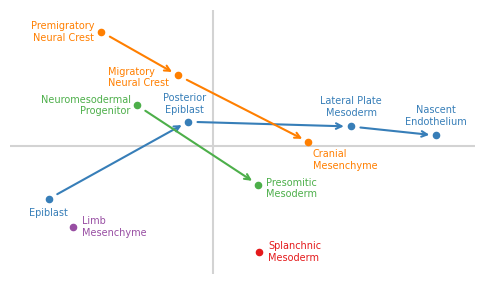

In [6]:
labels = []
cmap = plt.cm.Set1
arrowprops = {
    'arrowstyle' : '->',
    'linewidth'  : 1.5,
    'shrinkA'    : 7,
    'shrinkB'    : 5}

# plot embedding
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
for i, src in enumerate(src_train):
    X_src = attr_pca.loc[src]
    c = cmap(i)
    arrowprops['color'] = c
    for j in range(X_src.shape[0]):
        coords = X_src.iloc[j]
        ax.scatter(*coords, s = 20, color = c)
        labels.append(
            ax.text(*coords,
                    coords.name,
                    size = 7,
                    color = c,
                    zorder = 100))
        if j > 0:
            coords_prev = X_src.iloc[j - 1]
            ax.annotate('', coords_prev, coords,
                        arrowprops = arrowprops)

# adjust labels
plt.margins(.7, .7)
adjust_text(labels)
plt.margins(.1, .1)

label_dict = {
    'Posterior Epiblast'         : 'Posterior\nEpiblast',
    'Lateral Plate Mesoderm'     : 'Lateral Plate\nMesoderm',
    'Nascent Endothelium'        : 'Nascent\nEndothelium',
    'Neuromesodermal Progenitor' : 'Neuromesodermal\nProgenitor',
    'Presomitic Mesoderm'        : 'Presomitic\nMesoderm',
    'Premigratory Neural Crest'  : 'Premigratory\nNeural Crest',
    'Migratory Neural Crest'     : 'Migratory\nNeural Crest',
    'Cranial Mesenchyme'         : 'Cranial\nMesenchyme',
    'Splanchnic Mesoderm'        : 'Splanchnic\nMesoderm',
    'Limb Mesenchyme'            : 'Limb\nMesenchyme'}

ha_dict = {
    'Posterior Epiblast'         : 'center',
    'Lateral Plate Mesoderm'     : 'center',
    'Nascent Endothelium'        : 'center',
    'Neuromesodermal Progenitor' : 'right',
    'Presomitic Mesoderm'        : 'left',
    'Premigratory Neural Crest'  : 'right',
    'Cranial Mesenchyme'         : 'left'}

pos_dict = {
    'Epiblast'                   : (-.0275, -.025),
    'Posterior Epiblast'         : (0, .0075),
    'Lateral Plate Mesoderm'     : (-.005, .01),
    'Nascent Endothelium'        : (-.005, .04),
    'Neuromesodermal Progenitor' : (-.015, -.015),
    'Presomitic Mesoderm'        : (.005, -.02),
    'Premigratory Neural Crest'  : (-.015, -.015),
    'Migratory Neural Crest'     : (-.095, -.0175),
    'Cranial Mesenchyme'         : (.01, -.0375),
    'Splanchnic Mesoderm'        : (.0075, -.015),
    'Limb Mesenchyme'            : (.0075, -.015)}

for label in ax.texts:
    _label_ = label.get_text()
    x, y = label.get_position()
    if _label_ in label_dict:
        label.set_text(label_dict[_label_])
    if _label_ in ha_dict:
        label.set_ha(ha_dict[_label_])
    if _label_ in pos_dict:
        dx, dy = pos_dict[_label_]
        label.set_position([x + dx, y + dy])

ax.axvline(0, c = 'lightgray', zorder = 0)
ax.axhline(0, c = 'lightgray', zorder = 0)
ax.set_aspect(1); ax.axis(False)
fn = os.path.join(pth_out, 'semantics.pdf')
plt.savefig(fn, bbox_inches = 'tight')

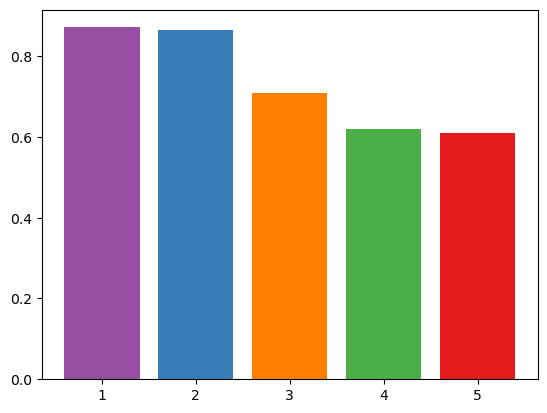

In [39]:
# PC1 vs. module attributions (correlation)
R = (pd.concat((attr_pca.PC1, attr), axis = 1)
     .corr().PC1.loc[src_train])
rank = R.rank(ascending = False).astype(int)
c = cmap(np.arange(R.size))

plt.figure()
plt.bar(rank, R, color = c)
plt.show()